In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Exercice 3. ##

We are interested in solving the time-dependentheat equation:

\begin{alignat}{2}
{\partial u\over\partial t} &= \nabla.(\kappa \nabla u) + f \quad &&\hbox{in }\Omega\times(0, T], \tag{1}\\
u &= u_{D1} = 350 &&\text{  on the side AB, BC, CD and DA},\quad \tag{2}\\
u &= u_{D2} =  400 &&\text{ on the side EF, FG, GH and HE},\quad \tag{3}\\
u &= u_{0} = 350 &&\mbox{at } t=0. \tag{4}
\end{alignat}
where $u({\bf x},t)$ is space-time-dependent function.

using **Implicit** scheme discretization using 25 steps in time and arbitrary FE discretization in space with given data:

* The domain $\Omega$ is shown in the figure below and the point $O$ is the middle of segment $[A, B]$

* $T = 0.5,$

* $\kappa = 22.5,$

* $f = (x^2+y^2)t,$

* $u_D = 350$  on external boundary of $\Omega$  and $u_D = 400$ on internal boundary of $\Omega$,

* $u_0 = 350.$

![image.png](attachment:image.png)

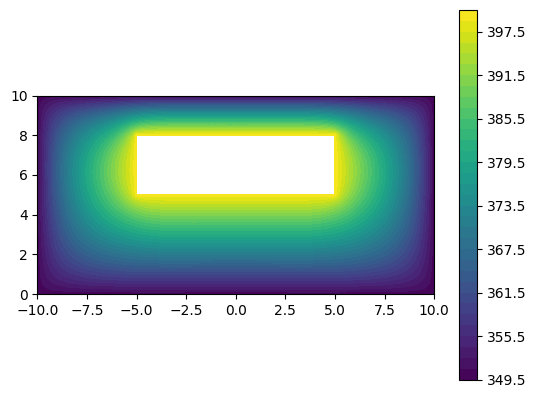

In [2]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from mshr import *

# to plot the result in the Notebook
%matplotlib inline

# Define the problem domain and mesh
domain = Rectangle(Point(-10.0, 0), Point(10.0, 10.0)) - Rectangle(Point(-5.0, 5.0), Point(5.0, 8.0))
mesh = generate_mesh(domain, 50)

V = FunctionSpace(mesh, 'P', 1)

# Define boundary conditions
u_D1 = Constant(350.0)
u_D2 = Constant(400.0)

def on_external_boundary(x, on_boundary):
    return on_boundary and (
        near(x[1], 0.0) or near(x[1], 10.0) or near(x[0], -10.0) or near(x[0], 10.0)
    )

def on_internal_boundary(x, on_boundary):
    return on_boundary and (
        near(x[1], 5.0) or near(x[1], 8.0) or near(x[0], -5.0) or near(x[0], 5.0)
    )

bc1 = DirichletBC(V, u_D1, on_external_boundary)
bc2 = DirichletBC(V, u_D2, on_internal_boundary)

# Define initial condition
u_0 = Constant(350.0)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
kappa = Constant(22.5)
f = Expression('pow(x[0], 2) + pow(x[1], 2)', degree=2)
dt = 0.02
T = 0.5
t = dt

a = u*v*dx + dt*kappa*dot(grad(u), grad(v))*dx
L = (u_n + dt*f)*v*dx

# Time-stepping
u = Function(V)
vtkfile = File('heat_solution.pvd')

while t <= T:
    solve(a == L, u, [bc1, bc2])
    u_n.assign(u)
    t += dt
    vtkfile << (u, t)

# Plot final solution
p = plot(u)
plt.colorbar(p)